In [ ]:
from z3 import *
import numpy as np
import re
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True # to for tight_layout()

from sat_metropolis import smt, mcmc, sat, utils

In [2]:
south_head = pd.read_csv("south_head.csv")
south_head

,,0-4 years,5-9 years,10-14 years,15-19 years,20-24 years,25-29 years,30-34 years,35-39 years,40-44 years,45-49 years,50-54 years,55-59 years,60-64 years,65-69 years,70-74 years,75-79 years,80-84 years,85-89 years,90 years and over
0,Male,3,6,6,12,9,3,9,9,6,6,15,6,3,6,3,3,0,0,0
1,Female,6,0,3,6,3,6,3,9,3,6,9,6,9,3,3,3,0,0,0
2,Total,15,3,12,15,15,12,9,18,9,12,21,12,12,12,6,0,0,0,0


In [3]:
# Assumption, all bit-vectors are of the same size
num_bits = 5
num_vars = 19*2
var_list = [BitVec(f'x{i}',num_bits) for i in range(num_vars)]
x = var_list
g = Goal()
sat.add_bool_vars_to_goal(g, var_list)

#Add contraints
numpy_data = south_head.to_numpy()[:,1:]

for i in range(19):
    g.add(ULE(x[i],numpy_data[0,i]+2))
    if(numpy_data[0,i]>0):
        g.add(ULE(numpy_data[0,i]-2,x[i]))

    g.add(ULE(x[i+19],numpy_data[1,i]+2))
    if(numpy_data[1,i]>0):
        g.add(ULE(numpy_data[1,i]-2,x[i+19]))

    g.add(ULE(x[i+19] + x[i], numpy_data[2,i]+2))
    if(numpy_data[2,i]>0):
        g.add(ULE(numpy_data[2,i]-2,x[i+19]+x[i]))

In [4]:
trace = mcmc.sample_mh_trace_from_z3_model(backend='cmsgen',
                                           z3_problem=g,
                                           num_vars=num_vars,
                                           num_bits=num_bits,
                                           num_samples=10000, 
                                           num_chains=4)

c CMSGen Copyright Mate Soos (soos.mate@gmail.com)
c CMSGen SHA revision 422a9dbaba3f749c2df811d9dfab7ffd4627bac5
c CMSGen is MIT licensed
c CMSGen compilation env CMAKE_CXX_COMPILER = /usr/bin/c++ | CMAKE_CXX_FLAGS =  -mtune=native -Wall -Wextra -Wunused -Wsign-compare -fno-omit-frame-pointer -Wtype-limits -Wuninitialized -Wno-deprecated -Wstrict-aliasing -Wpointer-arith -Wpointer-arith -Wformat-nonliteral -Winit-self -Wparentheses -Wunreachable-code -ggdb3 -Wno-class-memaccess -Wlogical-op -Wrestrict -Wnull-dereference -Wdouble-promotion -Wshadow -Wformat=2 -Wextra-semi -pedantic | COMPILE_DEFINES =  -DUSE_GAUSS -DUSE_ZLIB -DYALSAT_FPU | STATICCOMPILE = OFF | ZLIB_FOUND = TRUE | VALGRIND_FOUND =  | ENABLE_TESTING =  | SLOW_DEBUG = OFF | ENABLE_ASSERTIONS = ON | MY_TARGETS =  | LARGEMEM =  | LIMITMEM =  | 
c CMSGen compiled with gcc version 13.2.0
c executed with command line: cmsgen --samples 10000 --samplefile cmsgen_input/cmsgen_samples.out cmsgen_input/z3_problem.cnf
c Writing sam

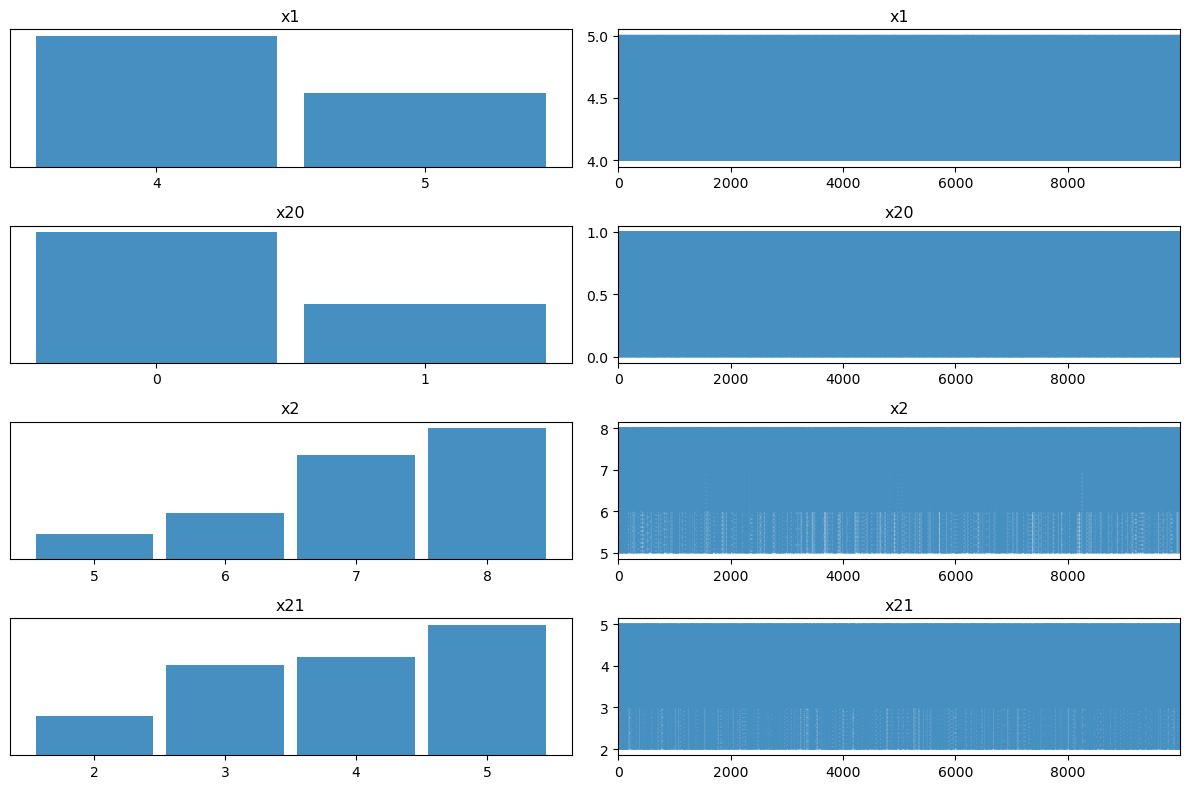

In [5]:
# Plot the posterior
az.plot_trace(trace, var_names=['x1', 'x20', 'x2', 'x21']);
plt.savefig('cmsgen_trace_plot_nz_db.png', dpi=150);

In [6]:
# Diagnostics
az.summary(trace)

/home/pardo/programs/miniconda3/envs/mcmc_sat/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc_sat/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc_sat/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc_sat/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,5.000,0.000,5.0,5.0,0.000,0.000,40000.0,40000.0,NaN
x1,4.360,0.480,4.0,5.0,0.002,0.002,40063.0,40000.0,1.0
x2,7.111,0.947,5.0,8.0,0.005,0.003,40340.0,40000.0,1.0
x3,11.002,0.975,10.0,13.0,0.005,0.003,39335.0,39868.0,1.0
x4,10.223,0.961,8.0,11.0,0.005,0.003,40231.0,39890.0,1.0
x5,3.904,1.006,2.0,5.0,0.005,0.004,40116.0,39864.0,1.0
x6,7.878,1.021,7.0,10.0,0.005,0.004,39346.0,39218.0,1.0
x7,8.932,1.424,7.0,11.0,0.007,0.005,40161.0,40000.0,1.0
x8,6.150,1.381,4.0,8.0,0.007,0.005,39891.0,40000.0,1.0
x9,6.102,1.391,4.0,8.0,0.007,0.005,40698.0,40000.0,1.0
